# Facial Detection and Focal Point Estimation IPYNB for Embody Interview
(George Alexander Wheelis - 12/12/21)

In [25]:
import dlib
import cv2

import matplotlib.pyplot as plt
import glob
from skimage import io
import numpy as np

from imutils import face_utils


%matplotlib inline

# Bounding Boxes and a Focus Face

In [26]:
def detect_face(img): # function created from the script below

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1, 
    minNeighbors=5,
    flags=cv2.CASCADE_SCALE_IMAGE
    )
    print(len(faces))
    if len(faces) == 0:
        return

    elif len(faces) == 1:
        x, y, w, h = faces[0]
        cv2.rectangle(img, (x, y), (x+w, y+h), color = (0,255,0), thickness = 10)
        return
    
    else:
        def bb_box_useful(pic_dims, bbox): 
            """
            pic_dims: arr of shape
            bbox: arr/list of shape (x, y, w, h)

            returns: bool

            fucntion
            --------
            decide if a bounding box is > 10% of the desired area
            """
            pic_area = .8*(pic_dims[0] * pic_dims[1])
            bbox_area = bbox[2] * bbox[3]
            return bbox_area > (pic_area * .01)
        new_faces = []
        for face in faces: 

            if (bb_box_useful(img_c.shape, face)):
                new_faces.append(face)


        faces = np.array(new_faces)

        img_midpoint = np.array([int(img_c.shape[1]/2), int(img_c.shape[0]/2)])

        faces_midpoints = np.vstack([faces[:,0]+faces[:,2]/2, faces[:,1]+faces[:,3]/2])

        fs = np.vstack([abs(np.subtract(faces_midpoints[0,:],img_midpoint[0])), \
                        abs(np.subtract(faces_midpoints[1,:],img_midpoint[1]))])

        fs = np.sum(fs, axis = 0)
        focus_face = np.argmin(fs) if faces.shape[0] > 1 else 0

        for i, (x, y, w, h) in enumerate(faces): 
            if focus_face == i: 
                color = (0,255,0)

            else:
                # else, bound in red 
                color = (255,0,0)
            cv2.rectangle(img, (x, y), (x+w, y+h), color = color, thickness = 10)
        return

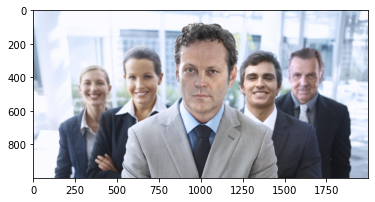

In [42]:
# pull a test image, read it, and show it. 
imgs = glob.glob("/Users/alex_wheelis/Downloads/test_imgs/*")
sel_img = imgs[3]
img_c = io.imread(sel_img)
test1 = cv2.imread(sel_img)
#convert the test image to gray image as opencv face detector expects gray images
gray = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)
plt.imshow(img_c)
plt.show()


# use the opencv face detection module to id faces in pictures
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = faceCascade.detectMultiScale(
gray,
scaleFactor=1.1, 
minNeighbors=5,
flags=cv2.CASCADE_SCALE_IMAGE
)

In [43]:
"""
1) function to figure out if bounding box is useful (based off of 80% of the img area and the area of the bbox)
-- nothing < 10% (check) (IMPLEMENT FUNCTION BELOW)
2) detect multiple faces and draw a green box on the focus one and a red one on the others (check)
"""

def bb_box_useful(pic_dims, bbox): 
    """
    pic_dims: arr of shape
    bbox: arr/list of shape (x, y, w, h)
    
    returns: bool
    
    fucntion
    --------
    decide if a bounding box is > 10% of the desired area
    """
    pic_area = .8*(pic_dims[0] * pic_dims[1])
    bbox_area = bbox[2] * bbox[3]
    return bbox_area > (pic_area * .01)

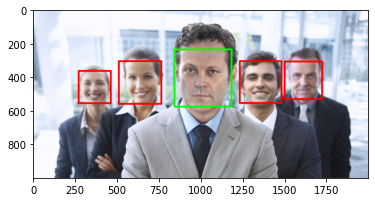

In [44]:
new_faces = []
for face in faces: 

    if (bb_box_useful(img_c.shape, face)):
        new_faces.append(face)


faces = np.array(new_faces)
# face[i] = (x, y, w, h)

# choose the face whose midpoint is closest to the center of the img
# get img midpoint
img_midpoint = np.array([int(img_c.shape[1]/2), int(img_c.shape[0]/2)])

# get midpoint of each face (x, y) for faces [n]
faces_midpoints = np.vstack([faces[:,0]+faces[:,2]/2, faces[:,1]+faces[:,3]/2])

# algorithm for finding the face closest to the center
fs = np.vstack([abs(np.subtract(faces_midpoints[0,:],img_midpoint[0])), \
                abs(np.subtract(faces_midpoints[1,:],img_midpoint[1]))])

# ternary operation takes care of the 1 face and n face case
fs = np.sum(fs, axis = 0)
focus_face = np.argmin(fs) if faces.shape[0] > 1 else 0

for i, (x, y, w, h) in enumerate(faces): 
#     print(i)
    if focus_face == i: 
        # if the face is the closest to the center, bound in green
        color = (0,255,0)
        
    else:
        # else, bound in red 
        color = (255,0,0)
    cv2.rectangle(img_c, (x, y), (x+w, y+h), color = color, thickness = 10)

plt.imshow(img_c)
plt.show()

# Face Focal Points & Head Pose 

In [30]:
def draw_features(image, shape):
    # find the bouding box of the face based off of min and max xy coordinates
    bbox_face = shape[np.argmin(shape[:,0])], shape[np.argmax(shape[:,0])],\
     shape[np.argmin(shape[:,1])], shape[np.argmax(shape[:,1])]
    bbox_face = np.array(bbox_face)

    # bounding box points 
    top_left = bbox_face[:, 0].min(), bbox_face[:, 1].min()
    top_right = bbox_face[:, 0].max(), bbox_face[:, 1].min()
    bottom_right = bbox_face[:, 0].max(), bbox_face[:, 1].max()
    bottom_left = bbox_face[:, 0].min(), bbox_face[:, 1].max()
    
    # midpoints on the left, right, and center of face box
    # used to calculate the angle below
    left_side_midpoint = np.array([(top_left[0] + bottom_left[0])/2, (top_left[1] + bottom_left[1])/2])
    right_side_midpoint = np.array([(top_right[0] + bottom_right[0])/2, (top_right[1] + bottom_right[1])/2])
    face_box_midpoint = np.array([(top_right[0] + top_left[0])/2, (bottom_left[1] + top_left[1])/2])
#     face_centroid = np.sum(shape[:, 0])/shape.shape[0],np.sum(shape[:, 1])/shape.shape[0]
    
    # hard coded the nose 
    # this is used to figure out where the person is looking 
    nose = shape[30]
    
    # vector is used to determine pose
    nose_vect = nose-face_box_midpoint
    left_vect = left_side_midpoint - np.array(face_box_midpoint)
    # left_angle = np.arccos(np.dot(nose_vect,left_vect)/(np.linalg.norm(nose_vect)*np.linalg.norm(left_vect)))
    
    vect_from_nose = nose + nose_vect
    
    cv2.arrowedLine(image, (int(nose[0]), int(nose[1])), \
                    (int(vect_from_nose[0]), int(vect_from_nose[1])),\
                    (0,0,255),3, 8, 0, 0.1)
    
    return

In [31]:
p = "/Users/alex_wheelis/Downloads/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

cap = cv2.VideoCapture(0)

In [32]:
while True:
    # Getting out image by webcam 
    _, image = cap.read()
    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    
    # Get faces into webcam's image
    rects = detector(gray, 0)
    detect_face(image)
    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
        # Draw on our image, all the finded cordinate points (x,y) 
        
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
        
        draw_features(image, shape)
    
    # Show the image
    cv2.imshow("Output", image)
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cap.release()

0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
0
2
0
0
2
1
0
1
0
1
1
1
1
0
3
1
1
1
1
1
1
3
1
2
1
1
1
0
0
1
1
1
2
2
1
1
1
1
1
1
1
1
0
0
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
2
1
1
1
2
1
1
1
1
1
1
1
1
